# Iris DataSet Classification 

The Iris is well-known problem that involves the classification of three sets of Iris flowers. It is compose by three classes and 4 properties. In this work, we classify this dataset using a single qutrit in ibmq_bogota.
As IBMQ by default only uses two levels of the transmon qubit, which is in fact an anharmonic oscillator with an infinite set of levels, we need to calibrate subsequent levels in order to use them. This involves finding the transition frequency and the amplitude of the transition. In this work, we present a model for classification of the Iris dataset based only in one qubit, the idea is to use the power of pulse level control for this task:

* Finding the setup of transition to the state $|2\rangle$
    * Finding the frequency of the transition from $|1\rangle$ to $|2\rangle$
    * Finding the amplitude for such transition.
* Classification of the three states with Keras
* Iris data set extraction and normalization
* Paramaetrized circuit for the classification and Cost function model
* Regularization and training

In [134]:
from qiskit import IBMQ
from qiskit import QuantumCircuit, transpile
from qiskit import schedule
from qiskit.pulse import DriveChannel, Waveform, Gaussian
from qiskit.circuit import Parameter, ParameterVector
from qiskit.tools import job_monitor
from qiskit import pulse
import numpy as np
import matplotlib.pyplot as plt

In [3]:
provider = IBMQ.load_account()
backend = provider.backend.ibmq_bogota

# 1) Classification of the states

To understand the transmon qubit, we use the image below. Here, We can see in a), the representation of a harmonic oscillator which consists of a circuit with a capacitor and an inductor, in b) the inductor is changed for a Josephson junction which creates a non-linear flux, this makes the system non-linear and the transition between energy levels now is given by different frequencies, this is what we call an anharmonic oscillator, c) shows the energy separation in a harmonic oscillator and d) in an anharmonic one. (The image and the analysis are taken from [1] A Quantum Engineer’s Guide to Superconducting Qubits, Krantz et. al. 2019). The anharmonic configuration is desired because we can fix the frequency and restrict the anharmonic oscillator to mimic a qubit, what we call transmon qubit.

<img src="./Figures/anharmonic.png" width="600"> [1]

However, in our case, we want to find the frequency and the amplitude of the transition to the state $|2\rangle$, to work with what is call qutrit.

## 1.1) Finding the qubit frequency for transition between $|1\rangle$ and $|2\rangle$
Accessing the second level of the anharmonic oscillator $|2\rangle$, we need to know the anharmonicity, that means, knowing the difference in frequency from $|1\rangle$ and $|2\rangle$. In this section, we use a method to calibrate the transition frequency from state $|1\rangle$ to $|2\rangle$

In [5]:
x_def = backend.defaults().instruction_schedule_map.get('x',qubits = [0]) # Default x gate from IBM
qubit = 0 # The qubit that we will use in Bogota
amp = 0.4 # Guessed amplitude of the transition between |1> and |2>
duration = 160 # Duration of the Gaussian pulse for the transition
spec_pulse = Gaussian(duration=duration, amp=amp, sigma=(duration//4)) # Pulse for the transition
measure = backend.defaults().instruction_schedule_map.get('measure',qubits = [qubit]) # Default mesurement gate
num_exp = 20# number of experiments which means the different frequencies
f01 = backend.defaults().qubit_freq_est[0] # Default frequency estimation of transition |0> to |1>
frequencies = f01 - np.linspace(0,0.4e9,num_exp) # Going from the f01 to f01 - 0.4GHz Guessing where the transition frequency is.
scheds = [] # variable to storage the different experiments
for f in frequencies: # iterating over the frequencies
    with pulse.build() as Schedule:
        with pulse.align_sequential():
            pulse.call(x_def)
            pulse.set_frequency(f, DriveChannel(qubit))
            pulse.play(spec_pulse, DriveChannel(qubit))
            pulse.call(measure)
    scheds.append(Schedule)

In [6]:
shots = 1000 # Number of repetitions of the experiment (to obtain the probability)
job = backend.run(scheds, meas_level=1, meas_return="single", shots=shots) # What we send to ibmq_bogota
# meas_level = 1 means that we want to obtain the points in an I-Q diagram
job_monitor(job) # To visualize where in the queue is our experiment
cal_freq = job.result() # results from the job

/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run


In [7]:
output = []
for i in range(num_exp):
    output.append(cal_freq.get_memory(i))# each memory contains one of the 20 experiments with complex numbers the real and imaginary components represent the I-Q diagram
output = np.array(output)
output = np.squeeze(output)[:,:,0]

Text(0.5, 1.0, 'Frequency calibrated: 4.664 GHz')

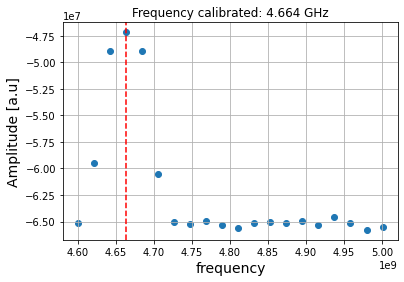

In [13]:
mean = np.mean(output, axis=1) # taken the mean over the 1000 shots
f12 = frequencies[np.argmax(mean.imag)] # The frequency will be the maximum amplitude for the imaginary term IN THIS CASE

plt.figure()
plt.scatter(frequencies, mean.imag)
plt.axvline(f12, linestyle="--", color="red")
plt.xlabel("frequency", fontsize=14)
plt.ylabel("Amplitude [a.u]", fontsize=14)
plt.grid()
plt.title(f"Frequency calibrated: {np.round(f12/1e9,3)} GHz")

As we can see in the image above, the transition frequency from $|1\rangle$ to $|2\rangle$ is given by the dashed line, where we see a jump in the imaginary component.


## 1.2) Amplitude calibration
Once we know the transition frequency between $|1\rangle$ and $|2\rangle$, we can calculate the amplitude of the pulse for such transition. This is make in this section.

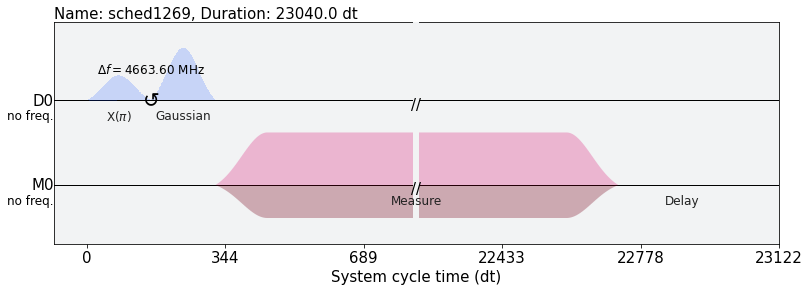

In [287]:
scheds = []
amplitudes = np.linspace(0,0.4,25) # Guessing the range of amplitudes that generates a transition between 1 and 2
for amp in amplitudes:
    spec_pulse = Gaussian(duration=duration, amp=amp, sigma=(duration//4))
    with pulse.build() as Schedule:
        with pulse.align_sequential():
            pulse.call(x_def)
            pulse.set_frequency(f12, DriveChannel(qubit))
            pulse.play(spec_pulse, DriveChannel(qubit))
            pulse.call(measure)
    scheds.append(Schedule)
scheds[-1].draw()

In [17]:
shots = 1000
job_amp = backend.run(scheds, meas_level=1, meas_return="single", shots=shots)
job_monitor(job_amp)
amp_cal = job_amp.result()

Job Status: job has successfully run


In [19]:
amps_12 = []
for i in range(len(amplitudes)):
    amps_12.append(amp_cal.get_memory(i))
amps_12 = np.array(amps_12)
amps_12 = np.squeeze(amps_12)[:,:,0]

Text(0, 0.5, 'Amplitude [a.u]')

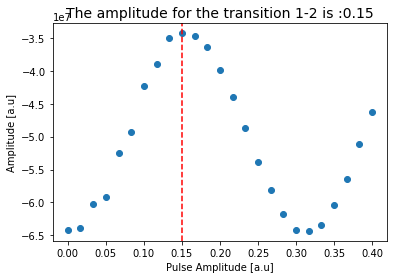

In [26]:
amps_12_mean = np.mean(amps_12, axis=1)
amp_12 = amplitudes[np.argmax(amps_12_mean.imag)]
plt.figure()
plt.plot(amplitudes,amps_12_mean.imag, "o", label = "Exp")
plt.axvline(amp_12, color="red", linestyle="--", label="Amp 12")
plt.title(f"The amplitude for the transition 1-2 is :{round(amp_12,3)}", fontsize=14)
plt.xlabel("Pulse Amplitude [a.u]")
plt.ylabel("Amplitude [a.u]")

## 2) Classification the three States with Keras

Now that we have the three states, we can find how they are distributed in an I-Q diagram. Also, this is useful to automatize the clusstering of the three states using Kmeans.

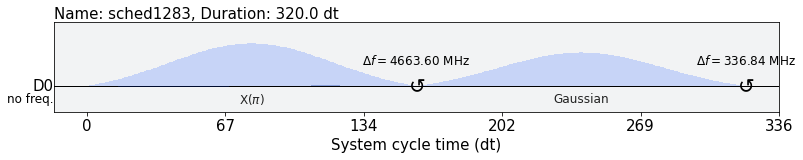

In [288]:
x01 = backend.defaults().instruction_schedule_map.get('x', qubits = [0]) # Gate X to rotate in the |0> |1> basis
f01 = backend.defaults().qubit_freq_est[0]
spec_pulse = Gaussian(duration=duration, amp=amp_12, sigma=(duration//4))
with pulse.build() as pulse12:
    with pulse.align_sequential():
        pulse.set_frequency(f12, DriveChannel(qubit))
        pulse.play(spec_pulse, DriveChannel(qubit))
        pulse.set_frequency(f01, DriveChannel(qubit))
x12 = pulse12
x02 = pulse.Schedule()
x02 += x01
x02 += x12
# |0>
zero = pulse.Schedule()
zero += measure
# |1>
one = pulse.Schedule()
one += x01
one |= measure << one.duration
# |2>
two = pulse.Schedule()
two += x02
two |= measure << two.duration

x02.draw()

In [30]:
classExp = backend.run([zero, one, two], meas_level=1, meas_return="single", shots=shots)
job_monitor(classExp)

Job Status: job has successfully run


In [31]:
resClass = classExp.result()

In [63]:
result = []
for i in range(3):
    result.append([resClass.get_memory(i).real, resClass.get_memory(i).imag])
result = np.squeeze(np.array(result)).T[0]

(1000, 2, 3)

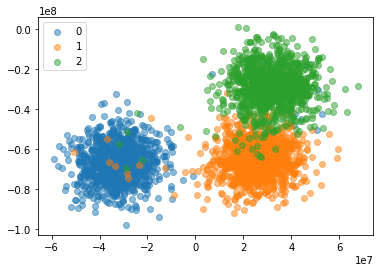

In [65]:
for i in range(3):
    plt.scatter(result[:,0,i], result[:,1,i], label = f"{i}", alpha = 0.5)
plt.legend()


### Classification using KMeans

In [66]:
from sklearn.cluster import KMeans

In [67]:
X = np.concatenate((result[:,:,0], result[:,:,1],result[:,:,2]))
kmeans = KMeans(n_clusters=3).fit(X)

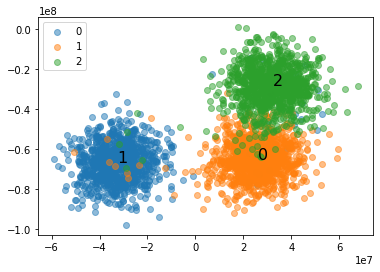

In [68]:
centers = kmeans.cluster_centers_
plt.figure()
for i in range(3):
    plt.scatter(result[:,0,i], result[:,1,i], label = f"{i}", alpha = 0.5)
    plt.text(centers[i][0], centers[i][1], f"{i}", fontsize=16)
plt.legend()

labels = [1,0,2]

[[0.973, 0.009, 0.018], [0.011, 0.965, 0.024], [0.006, 0.048, 0.946]]

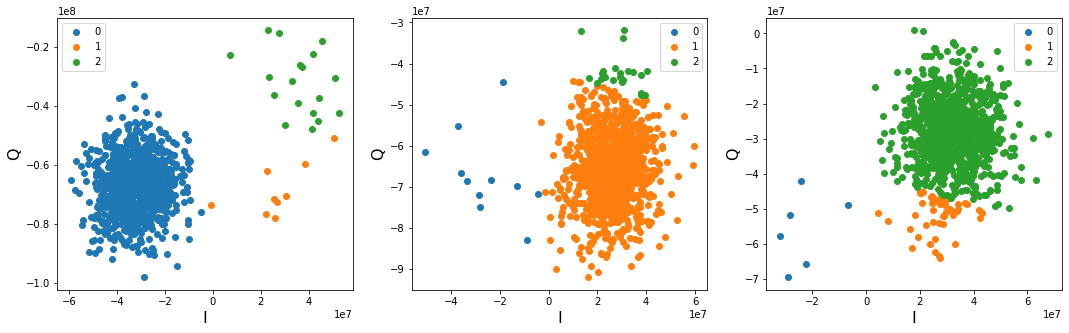

In [69]:
fig, ax = plt.subplots(1,3, figsize=(18,5))
count = []
for j in range(3):
    case = 2
    pred0 = kmeans.predict(result[:,:,j])
    for i in range(3):
        pred = result[pred0==labels[i],:,j]
        ax[j].scatter(pred[:,0],pred[:,1], label=f"{i}")
    ax[j].set_xlabel("I", fontsize=16)
    ax[j].set_ylabel("Q", fontsize=16)
    ax[j].legend()
    count.append([np.sum(pred0==labels[i])/len(pred0) for i in range(3)])
count

## Loading Dataset
The Irish data set is used here for clasification using the ibmq_bogota 

In [52]:
from sklearn import datasets

In [260]:
iris_dataset = datasets.load_iris(return_X_y=True)

data = iris_dataset[0]
minD = np.min(data, axis=0)
maxD = np.max(data, axis=0)

index = np.random.shuffle(np.arange(len(data)))
inputNorm = (1.8 * (data - minD) / (maxD - minD) - 0.9) * np.pi # for the inputs to be between 0.1π and 0.9π
inputNorm = inputNorm[index,:][0]
target = iris_dataset[1][index][0]

In [107]:
def gate_12(param):
    with pulse.build() as sched:
        with pulse.align_sequential():
            pulse.set_frequency(f12, DriveChannel(qubit))
            pulse.play(Gaussian(duration=duration, amp=param*amp_12/np.pi, sigma=(duration//4)), DriveChannel(qubit))
            pulse.set_frequency(f01, DriveChannel(qubit))
    return sched

def u3(theta, phi, lambda_):
    qc = QuantumCircuit(1)
    qc.u(theta,phi,lambda_, qubit)
    return schedule(transpile(qc,backend), backend)


In [142]:
one1 = u3(np.pi,-np.pi/2,np.pi/2)
one = one1 
one |= measure << one.duration
two = one1
two |= gate_12(np.pi) << two.duration
two |= measure << two.duration

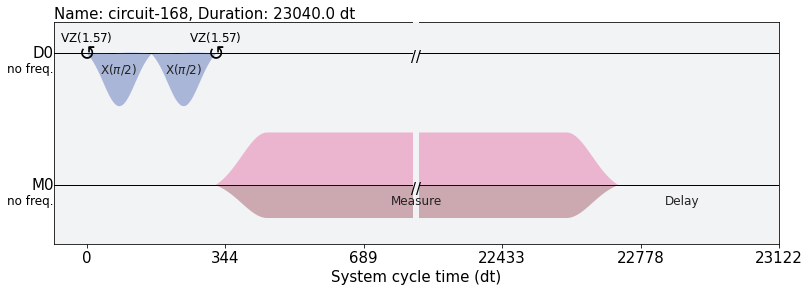

In [143]:
one.draw()


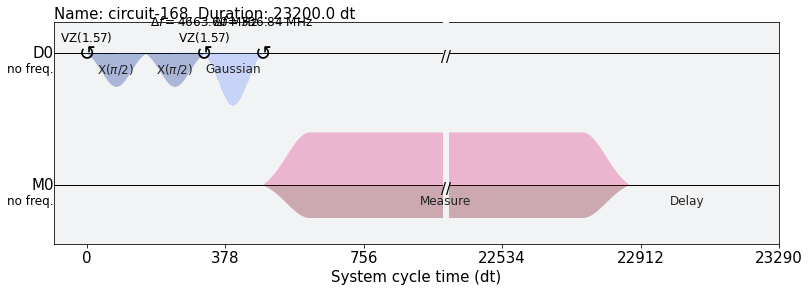

In [144]:
two.draw()

In [145]:
job = backend.run([one, two], meas_level=1, meas_return="single", shots=shots)
job_monitor(job)

/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run


In [146]:
aa = job.result()
result = []
for i in range(2):
    result.append([aa.get_memory(i).real, aa.get_memory(i).imag])
result = np.squeeze(np.array(result)).T[0]


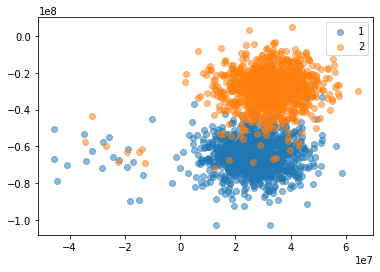

In [148]:
for i in range(2):
    plt.scatter(result[:,0,i], result[:,1,i], label = f"{i+1}", alpha = 0.5)
plt.legend()

In [153]:
from qiskit.pulse import Schedule

In [ ]:
from qiskit import Schedule

In [225]:
num_gates = 10
num_params = 2
x = ParameterVector("x",4)
params = ParameterVector("params", num_params)
list_of_params = list(x) + list(params)
QNN_Circuit = Schedule()
for i in range(num_gates):
    if np.random.rand() > 0.5:
        variables = np.random.choice(list_of_params,3)
        QNN_Circuit += u3(*variables)
    else:
        variables = np.random.choice(list_of_params,1)
        QNN_Circuit += gate_12(*variables)
QNN_Circuit += measure

In [226]:
Circuit = QNN_Circuit.assign_parameters({key:val for key, val in zip(list_of_params, value)}, inplace=False)

### Cost function 

In [282]:
def result_estrac(job_results, qubit=0, num_jobs=1):
    result = []
    for i in range(num_jobs):
        result.append([job_results.get_memory(i).real, job_results.get_memory(i).imag])
    return np.squeeze(np.array(result)).T[qubit]

def Class_fit(job_result):
    result = result_estrac(job_result)
    count = []
    pred0 = kmeans.predict(result)
    for i in range(3):
        pred = result[pred0==labels[i],:]
    count = [np.sum(pred0==labels[i])/len(pred0) for i in range(3)]
    return count

def loss_function(prediction, target):
    softmax = np.exp(prediction)/ np.sum(np.exp(prediction))
    target_vec = np.zeros((3,))
    target_vec[target] = 1
    cross_entropy = -np.sum(target_vec * np.log(softmax))
    return cross_entropy

def Cost(inputs, target, parameters):
    Circuit = QNN_Circuit.assign_parameters({key:val for key, val in zip(x, inputs)}, inplace=False)
    Circuit = Circuit.assign_parameters({key:val for key, val in zip(params, parameters)}, inplace=False)
    job = backend.run(Circuit, meas_level=1, meas_return="single", shots=shots)
    job_monitor(job)
    expResult = job.result()
    prediction = Class_fit(expResult)
    print(f"loss: {np.round(loss_function(prediction, target),3)}")
    return loss_function(prediction, target)

def total_cost(params, Xbatch, Ybatch):
    cost = 0
    for i, t in zip(Xbatch, Ybatch):
        cost += Cost(i, t, params)
    return cost

In [283]:
def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

In [284]:
from qiskit.algorithms.optimizers import SPSA

spsa_loss = []
def spsa_callback(nfev, x, fx, stepsize, accepted):
    spsa_loss.append(fx)

spsa = SPSA(maxiter=20, learning_rate=0.1, perturbation=0.1, callback=spsa_callback)



In [286]:
initial_point = np.random.rand(num_params)
num_batches = 80
for Xbatch, Ybatch in iterate_minibatches(inputNorm, target, num_batches):
    cost_fun = lambda params: total_cost(params, Xbatch, Ybatch)
    x_opt, fx_opt, nfevs = spsa.optimize(num_params, 
                                         cost_fun, 
                                         initial_point=initial_point)
    initial_point = x_opt
    print(f"Loss function: {fx_opt}, x_opt: {x_opt}")


Job Status: job has successfully run
loss: 0.899


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.934


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.902


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.948


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.888


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.826


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.901


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.912


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.922


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.978


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.882


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.926


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.989


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.905


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.889


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.827


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.856


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.86


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.856


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.851


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.844


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.84


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.871


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.864


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.983


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.973


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.886


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.885


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.893


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.958


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.998


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run
loss: 0.834


/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run


account._job_result_object_storage:WARNING:2021-08-10 02:31:19,678: An error occurred while sending download completion acknowledgement: "HTTPSConnectionPool(host='api-qcon.quantum-computing.ibm.com', port=443): Read timed out. (read timeout=None)"
/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


loss: 0.872


IBMQBackendApiError: 'Error submitting job: "HTTPSConnectionPool(host=\'api-qcon.quantum-computing.ibm.com\', port=443): Read timed out. (read timeout=None)"'